# Introduction

I want to do some NLP analysis of news headlines as an MVP to learn more about the tools involved in web scraping, and to answer some questions I have as a media consumer. The goal of this document is to scrape headlines from news sites and store them on my filesystem.

# Our case study: Fox News

Let's start with http://www.foxnews.com/.

Here is what the Fox homepage looked like on the morning of April 21 (PST). 

![alt='asdf'](fox-home-20180421T0722.png "hello")

***Python web-scraping:***

What can we do with this in Python? From a little bit of searching, I've [found](https://gist.github.com/Vimy/2b8e8482dc119bb01c47d16327826a58) a few libraries that can help:
- newspaper : http://newspaper.readthedocs.io/en/latest/
- BeautifulSoup : https://www.crummy.com/software/BeautifulSoup/bs4/doc/
- requests : http://docs.python-requests.org/en/master/

`requests` is a relatively low-level library for working with HTTP requests -- i.e., working with APIs or getting raw response data such as headers, status codes, etc. I don't anticipate having to use this much.

`BeautifulSoup` is a higher-level library designed to facilitate navigating an HTML parse tree -- in other words, we can use this to extract HTML elements easily.

Finally, `newspaper` is a domain-specific library designed to scrape and do basic NLP analysis of online news articles, including voluminous feature extraction: authors, publication date, body text, images and other media, summary, an `NLP()` method that I need to look at, and more.

In [1]:
from bs4 import BeautifulSoup
import requests

url = 'http://www.foxnews.com/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'lxml')

The `soup` object is a long, unformatted HTML string of the raw HTML response.

Unfortunately, `soup.prettify()` doesn't work here because Fox uses mostly `<span>` (I think).

***Scraping headlines and features:***

Let's get all the articles:

In [2]:
articles = soup.find_all(attrs={'class':'article'})
articles[0]

<article class="article story-1"><div class="m"><a data-video-id="5779143448001" href="http://video.foxnews.com/v/5779143448001/"><img alt="Who benefits most from leak of Mueller's Trump questions?" src="//a57.foxnews.com/media2.foxnews.com/BrightCove/694940094001/2018/05/02/480/270/694940094001_5779141279001_5779143448001-vs.jpg"/></a><span class="pill duration"><a class="pill-link" href="http://video.foxnews.com/v/5779143448001/">9:43</a></span></div><div class="info"><header class="info-header"><div class="meta"><span class="eyebrow is-showpage"><a href="//www.foxnews.com/shows.html">the ingraham angle</a></span></div><h2 class="title"><a href="http://video.foxnews.com/v/5779143448001/">Who benefits most from leak of Mueller's Trump questions?</a></h2></header></div></article>

In [3]:
testcase = articles[0]
testcase

import re

def extractArticleFeatures(article):
    res = dict()
    
    # Get headline
    headline = article.find(attrs={'class':'title'}).string
    res['headline'] = headline
    
    # Get URL
    url = article.find(attrs={'class':'title'}).a['href']
    res['url'] = url
    
    # Check if the article was spotlighted at the time
    classes = []
    p = article
    while p.name != '[document]':
        classes = classes + p.get('class', [None])
        p = p.parent
    spotlight = any(['spotlight' in cls for cls in classes if cls is not None])
    res['spotlight'] = spotlight
    
    return res
    
extractArticleFeatures(testcase)

{'headline': "Who benefits most from leak of Mueller's Trump questions?",
 'url': 'http://video.foxnews.com/v/5779143448001/',
 'spotlight': False}

Other things we could extract:
* is_video
* image_url
* order in collection

In [4]:
import pandas as pd

articles = pd.DataFrame(list(map(extractArticleFeatures, articles)))
articles.head()

,headline,spotlight,url
0,Who benefits most from leak of Mueller's Trump...,False,http://video.foxnews.com/v/5779143448001/
1,Professor says he was fired for defending free...,False,http://video.foxnews.com/v/5779145414001/
2,Freedom Caucus members draft Rosenstein impeac...,False,http://video.foxnews.com/v/5779147449001/
3,Tucker: Policies Trump ran on considered evide...,False,http://video.foxnews.com/v/5779102634001/
4,Trump slams 'disgraceful' leak of Mueller ques...,False,http://video.foxnews.com/v/5779055244001/


# Analysis

Starting at 6am on April 28, I've been scraping Fox headlines every hour. I'd like to use this dataset as an opportunity to:

1. Learn Python web-scraping skills
2. Learn NLP skills
3. Satisfy some curiosity about the media

At some point, this project may develop in a couple of ways. First, it could become a predictive modeling project -- probably classification of headlines into authors or news sources, but there are other options. Second, it may become a fruitful avenue to study some questions about the media of political importance. For example, can we measure "bias" of a news source? I have done some background reading of Pew's work on American media consumption, which has been a good source of information about the top news outlets. In particular, I have a list of the top news sites referenced in tweets at the beginning of Trump's presidency. Since Twitter has become much more important to political conversation concurrent with Trump's election, it isn't unreasonable to think of this as a snapshot of the sources routinely used in social media conversation. The main drawback of using this list is that it relies on data from only one _pathway_ to news, namely Twitter. Twitter may differ from other social media, which may differ from other pathways generally. In fact, given that TV has still not quite been supplanted by digital information sources, it would be wise to understand that this study I am thinking about would be prospective and exploratory -- a sign of what's to come, if you will. In short, the news of the future will be online, on a news website like foxnews.com, and the people of the future will find their content (articles, videos, photoessays, etc.) by reading and clicking on headlines.

Preprocessing:
* Deduplicate headlines
* Convert to lowercase
* Strip punctuation
* Stemming

Questions:
* Basic info:
    * How many words (over time)? How many observations per word (over time)? Top words (over time)? Total observations (over time)?
    * Can we identify entities? See [NER](https://en.wikipedia.org/wiki/Named-entity_recognition). Redo basic info above with entities as vocabulary.
    * What parts of speech are most common? How complex is Fox's headline structure?
    * [Can](https://www.digitalocean.com/community/tutorials/how-to-graph-word-frequency-using-matplotlib-with-python-3) we [visualize](http://archive.nytimes.com/www.nytimes.com/interactive/2011/06/10/education/commencement-speeches-graphic.html) frequencies [nicely](https://www.cs.sfu.ca/~anoop/papers/pdf/anoop_maryam-canvas-2013.pdf)? [Interactively](https://plot.ly/python/getting-started/)?
* Analysis:
    * Can we identify topics? (Visualize/cluster in PCA space. Hierarchical clusetering would be good.)
    * Context [networks](https://medium.com/district-data-labs/beyond-the-word-cloud-428e3c25b59c)
    * Article networks based on common topics. Can we identify meta-headline narratives?
    * Is there anything interesting about quotes as context windows? Who does Fox tend to quote?
    * Can we measure sentiment? How does sentiment correlate to entities/topics/narratives covered? Can we measure sentiment _toward_ an entity/topic?
    * How diverse is Fox's vocabulary compard to other news sites?

***Load and massage the data:***

The data are saved each hour in a single CSV of headlines and accompanying info. I would like to collect this all into one dataframe by having two columns: the headline, and the scrape datetime, and then deduplicate based on both fields.

In [264]:
ls = !ls fox/
timestamps = [(lambda f: f[:f.find('.')])(f) for f in ls]
dfs = [pd.read_csv('fox/' + f) for f in ls]
for i, df in enumerate(dfs):
    df['timestamp'] = timestamps[i]
headlines = (pd.concat([df[['timestamp', 'headline', 'spotlight']] for df in dfs]).drop_duplicates().dropna())
headlines.sort_values(by=['timestamp', 'headline'], inplace=True)
headlines['timestamp'] = pd.to_datetime(headlines['timestamp'])
print(headlines.shape)
headlines.head()

(17177, 3)


,timestamp,headline,spotlight
150,2018-04-28 06:00:00,'Golden State Killer' suspect makes first cour...,False
91,2018-04-28 06:00:00,'Monster' walleye fish caught in Iowa lake,False
115,2018-04-28 06:00:00,"'Old house smell': What causes it, and how to ...",False
32,2018-04-28 06:00:00,"1,326-pound great white shark Hilton spotted o...",False
93,2018-04-28 06:00:00,5 reasons to eat more wild game,False


# Headline-level analysis

In [265]:
print(headlines.shape[0])
print(headlines['headline'].unique().shape[0])

17177
1578


There are 16,272 observations, but only 1,425 unique headlines. Let's look at headline uptime.

***Headline uptime and churn:***

The dataframe below has one column per headline and one row per hour. The cell value is 1 if the headline was on the Fox News website at that time.

In [266]:
overtime = headlines.groupby(['timestamp', 'headline']).apply(lambda grp: len(grp) > 0).astype(int).unstack()
overtime.head(1)

headline,'A teachable moment': Veterans talk to teens who defaced American flag,'Avengers' star says WWE stopped speaking to him about getting back in the ring,'Avengers' star says WWE stopped taking his calls about getting back in the ring,"'Avengers' star slams 'cleavage corset' costume, would like to 'cover up a bit'",'Avengers: Infinity War' dominates box office,'Avengers: Infinity War' topples 'Star Wars' for best box office opening ever,'Big Bang Theory' cast member Kaley Cuoco shares heartfelt birthday tributes to co-stars,'Can you hear me now?' Verizon guy recalls financial struggles: 'I never felt secure','Caravan of migrants' arrives at US border,'Clear History' privacy tool announced ahead of Facebook's F8 conference,...,Yellowstone geyser erupts for 3rd time in 6 weeks,YouTube Vlogger hit by tractor trailer while livestreaming from driver's seat,YouTube star hit by tractor trailer while livestreaming,"YouTube, dealing with advertiser uproar, defends controversial cleric's videos",Young cop shot dead while he sat inside home with his daughter,Young off-duty cop shot dead while he sat inside home with his daughter,‘Avengers: Infinity War’ poised for China box office record: IMAX CEO,‘I am Jack the Ripper’: Chilling postcard up for auction,‘Sisterhood of the Traveling Pants 3’ pitched by cast members,‘Southern Charm’ star accused of rape
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-28 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN


In [267]:
overtime.shape

(95, 1578)

We have 90 hours of observations for 1,425 headlines.

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Spotlighted headlines:

In [269]:
spotlight = headlines.loc[headlines['spotlight'], ['timestamp', 'headline']].groupby(['timestamp', 'headline']).apply(lambda grp: len(grp) > 0).astype(int).unstack()

C:\Anaconda3\envs\media\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


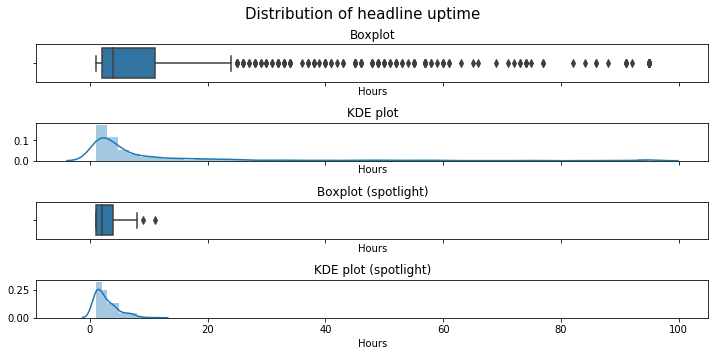

In [270]:
f, axarr = plt.subplots(4, 1, sharex=True, figsize=(10,5))

sns.boxplot(overtime.sum(), ax=axarr[0])
axarr[0].set(title='Boxplot', xlabel='Hours')

sns.distplot(overtime.sum(), ax=axarr[1])
axarr[1].set(title='KDE plot', xlabel='Hours')

sns.boxplot(spotlight.sum(), ax=axarr[2])
axarr[2].set(title='Boxplot (spotlight)', xlabel='Hours')

sns.distplot(spotlight.sum(), ax=axarr[3])
axarr[3].set(title='KDE plot (spotlight)', xlabel='Hours')

f.suptitle('Distribution of headline uptime', size=15)

plt.tight_layout(rect=[0,0,1,0.95])

In [271]:
overtime.sum().describe()

count    1578.000000
mean       10.874525
std        17.657295
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max        95.000000
dtype: float64

In [272]:
spotlight.sum().describe()

count    170.000000
mean       2.782353
std        1.962590
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       11.000000
dtype: float64

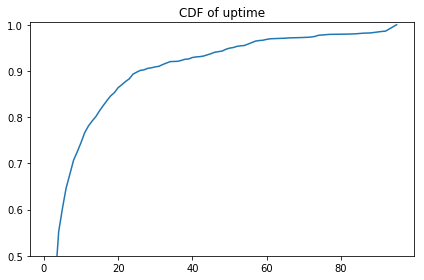

In [273]:
def cdf(series, title='uptime'):
    overtime = series
    srs = overtime.sum()
    ax = srs.value_counts().sort_index().div(srs.value_counts().sum()).cumsum().plot(title='CDF of {}'.format(title))
    ax.set(ylim=[0.5,1.005])
    plt.tight_layout()

cdf(overtime)

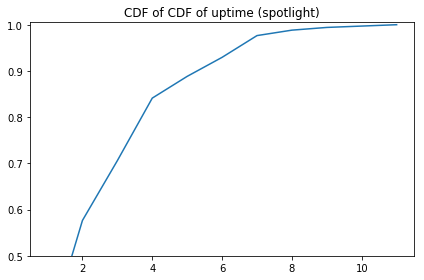

In [274]:
cdf(spotlight, title='CDF of uptime (spotlight)')

Gini coefficients:

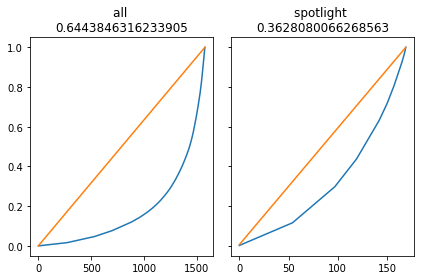

In [275]:
f, axarr = plt.subplots(1, 2, sharey=True)

cdf = overtime.sum().sort_values().div(overtime.sum().sum()).cumsum().reset_index(drop=True)
degree45 = pd.Series([(1 / cdf.shape[0]) * (i + 1) for i in range(len(cdf))]).reset_index(drop=True)
A = (degree45 - cdf).sum()
B = cdf.sum()
gini = A / (A + B)
overtime.sum().sort_values().div(overtime.sum().sum()).cumsum().reset_index(drop=True).plot(title='all \n{}'.format(gini), ax=axarr[0])
degree45.plot(ax=axarr[0])

cdf = spotlight.sum().sort_values().div(spotlight.sum().sum()).cumsum().reset_index(drop=True)
degree45 = pd.Series([(1 / cdf.shape[0]) * (i + 1) for i in range(len(cdf))]).reset_index(drop=True)
A = (degree45 - cdf).sum()
B = cdf.sum()
gini = A / (A + B)
spotlight.sum().sort_values().div(spotlight.sum().sum()).cumsum().reset_index(drop=True).plot(title='spotlight \n{}'.format(gini), ax=axarr[1])
degree45.plot(ax=axarr[1])

plt.tight_layout()

Some headlines have run much longer than others, but most are replaced in 12 hours or less, and almost all within a day. This indicates high churn, perhaps reflecting the chaotic online news cycle that has no doubt been exacerbated by the Trump administration. The 90-hour headlines are mostly lower vertically on the site and are lower-quality lifestyle pieces. The spotlight is prime real estate, reserved for the most newsworthy headlines which, in turn, churn much faster. A typical spotlight headline only lasts less than 6 hours!